## Pendulum: Two-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import *
from data_loader import *

In [3]:
model = 'pendulum'

1. This u will be drawn from a GP and in order to generate a test set we again draw from the same GP with another bandwidth and scaled to represent a small perturbation. 
2. We still have the access to the derivatives. Check how derivatives are computed. 
3. Draw from a GP and add those value to the sine. 

### Solution: Two-Step Method

> Step 1: Learning $u's$

In [4]:
optim_sgm, alphas, optim_lmbd = kernel_parameters(x_train.reshape(-1,1),u_train,e)

In [5]:
optim_sgm, optim_lmbd 

(array([0.39989901, 0.39989901, 0.39989901]),
 array([4.83293024e-07, 4.83293024e-07, 4.83293024e-07]))

In [6]:
u_pred_train, u_x_pred_train, u_xx_pred_train = predictions_ode(x_train, x_train, Gaussian, optim_sgm, alphas,e)
#u_pred_test,  u_x_pred_test,  u_xx_pred_test  = predictions_ode(x_test,  x_train, Gaussian, optim_sgm, alphas)

In [7]:
# Save true values to warm up the onepfive method
np.save('data/u_pred_train.npy', u_pred_train)
# Save true gradients for comparing later
np.save('data/u_x_train.npy',u_x_train)
np.save('data/u_xx_train.npy',u_xx_train)
# Save gradients for one step method
np.save('data/u_x_pred_train.npy',u_x_pred_train)
np.save('data/u_xx_pred_train.npy',u_xx_pred_train)

In [8]:
x_train

array([0.01037415, 0.08405965, 0.13382953, 0.14211109, 0.21855868,
       0.24810117, 0.34549864, 0.41850818, 0.49577329, 0.50187459,
       0.01037415, 0.08405965, 0.13382953, 0.14211109, 0.21855868,
       0.24810117, 0.34549864, 0.41850818, 0.49577329, 0.50187459,
       0.01037415, 0.08405965, 0.13382953, 0.14211109, 0.21855868,
       0.24810117, 0.34549864, 0.41850818, 0.49577329, 0.50187459])

Normalized MSE :  = 1.8698509900011936e-08
Normalized MSE :  = 8.427283295468807e-06
Normalized MSE :  = 0.000503910277079677
Normalized MSE :  = 3.4991513473435164e-09
Normalized MSE :  = 0.00038335477810927794
Normalized MSE :  = 0.026989470603255846
Normalized MSE :  = 4.8741989090196014e-09
Normalized MSE :  = 6.246808367521763e-05
Normalized MSE :  = 0.08745213878817978


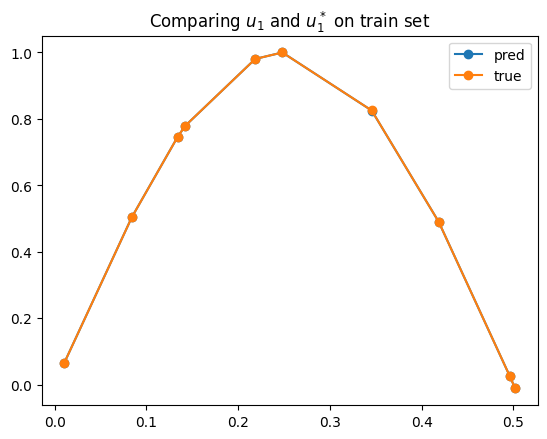

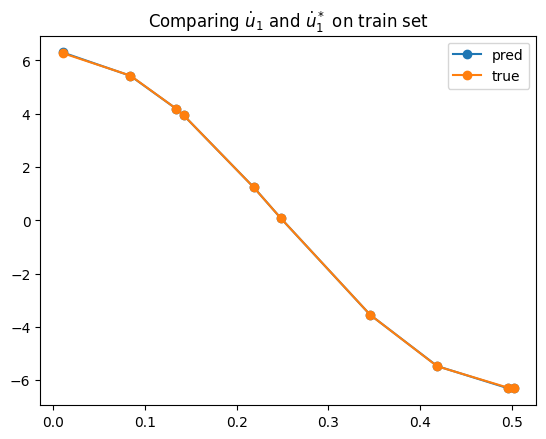

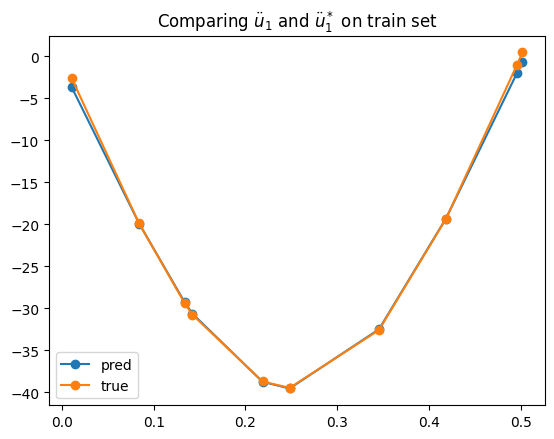

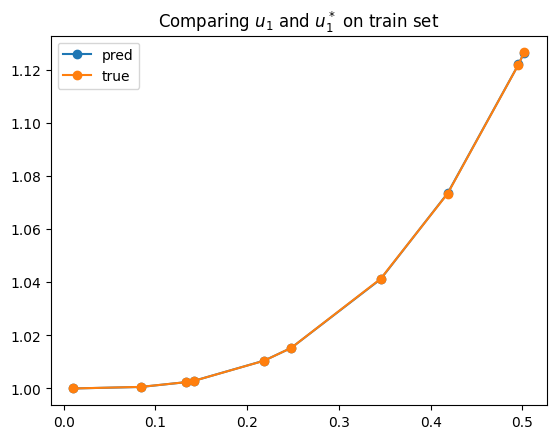

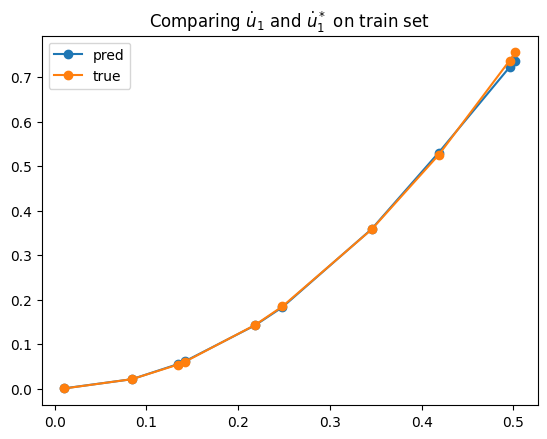

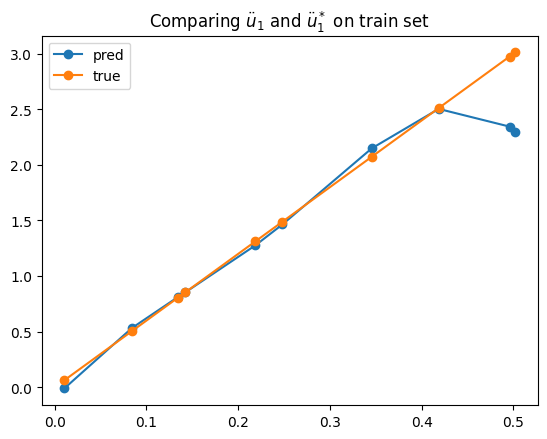

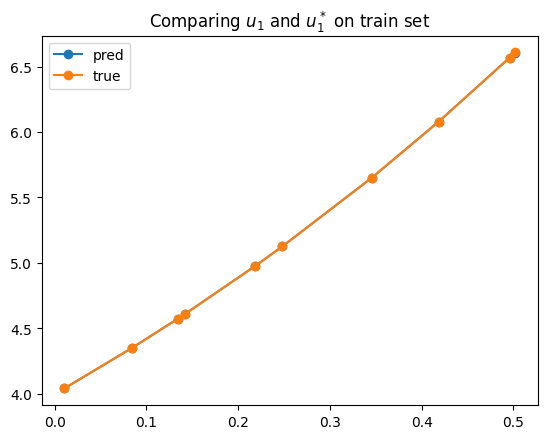

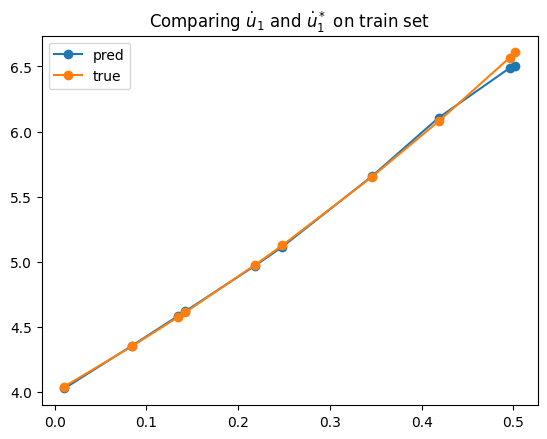

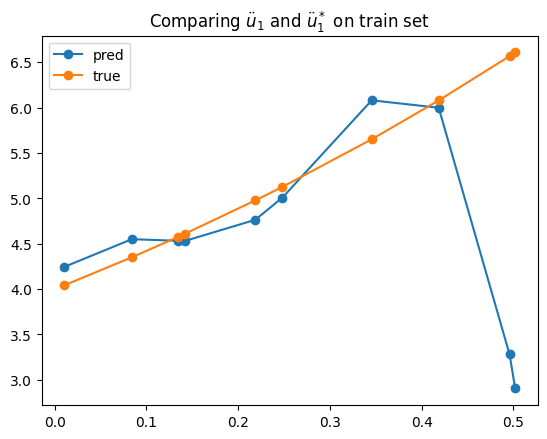

In [9]:
for i in range(3):
    mse_ui    = mse_plot(x_train[e*i:e*(i+1)], u_train[:,i],    u_pred_train[:,i],    title = 'Comparing $u_1$ and $u_1^*$ on train set')
    mse_ui_x  = mse_plot(x_train[e*i:e*(i+1)], u_x_train[:,i],  u_x_pred_train[:,i],  title = 'Comparing $\dot u_1$ and $\dot u_1^*$ on train set')
    mse_ui_xx = mse_plot(x_train[e*i:e*(i+1)], u_xx_train[:,i], u_xx_pred_train[:,i], title = 'Comparing $\ddot u_1$ and $\ddot u_1^*$ on train set')
plt.show()

> Step 2: Learning $P$

In [10]:
x_train_all

array([[0.01037415],
       [0.08405965],
       [0.13382953],
       [0.14211109],
       [0.21855868],
       [0.24810117],
       [0.34549864],
       [0.41850818],
       [0.49577329],
       [0.50187459],
       [0.01037415],
       [0.08405965],
       [0.13382953],
       [0.14211109],
       [0.21855868],
       [0.24810117],
       [0.34549864],
       [0.41850818],
       [0.49577329],
       [0.50187459],
       [0.01037415],
       [0.08405965],
       [0.13382953],
       [0.14211109],
       [0.21855868],
       [0.24810117],
       [0.34549864],
       [0.41850818],
       [0.49577329],
       [0.50187459]])

In [11]:
s_train = np.hstack((x_train_all.reshape(-1,1),u_pred_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1),u_xx_pred_train.T.reshape(-1,1)))  # 30 * 4
f_train = f_Train(model)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)

In [12]:
optim_sgm_P, optim_lmbd_P = grid_search_RBF(s_train_s,f_train)
krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_lmbd_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 

In [13]:
optim_sgm_P, optim_lmbd_P

(1.7343997911885616, 3.792690190732246e-05)

In [14]:
f_pred_train

array([ -2.53928947, -19.31545227, -28.78974294, -30.10382498,
       -37.84465451, -38.57527569, -31.95838718, -18.77018236,
        -0.99194816,   0.38874777,   0.88146855,   1.41401616,
         1.65959468,   1.69726717,   2.07474197,   2.2544563 ,
         2.98671023,   3.52315758,   3.8462293 ,   3.85657402,
         3.27359804,   3.50989457,   3.55412695,   3.56753686,
         3.9035352 ,   4.14814771,   5.2042921 ,   5.96674054,
         6.79824901,   6.87698932])

In [15]:
f_train

array([ -2.5063987 , -19.41214312, -28.74225768, -30.04725109,
       -37.87976066, -38.63417539, -31.8473875 , -18.87172785,
        -1.02176136,   0.45320437,   0.90371651,   1.34614967,
         1.64574081,   1.6956847 ,   2.15841788,   2.33823087,
         2.93602409,   3.38982985,   3.87554758,   3.91412273,
         3.25831114,   3.41544802,   3.58251957,   3.61597258,
         4.0119673 ,   4.21082695,   5.0596874 ,   5.87577736,
         6.84715551,   6.92569061])

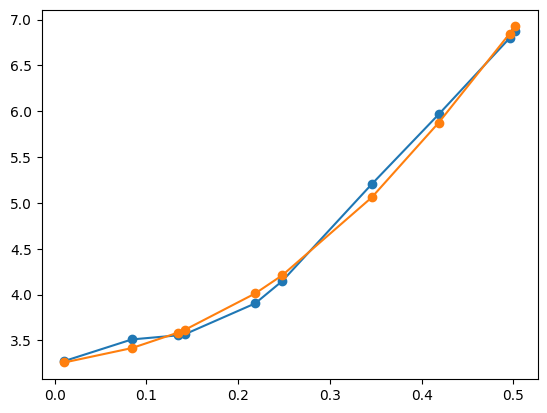

In [16]:
plt.plot(x_train[2*e:3*e], f_pred_train[2*e:3*e],marker= 'o')
plt.plot(x_train[2*e:3*e], f_train[2*e:3*e],marker= 'o')
plt.show()

**Testing**: We recreate three scenarios. All of them are passing the sanity check that if we add noise 0 we should get a small mse. 

Also, we have two types of experiments:
1. we add the noise and then rescale the perturbed data
2. we just apply noise directly to the scaled data

>Test 1: Add arbitrary noise to observations.

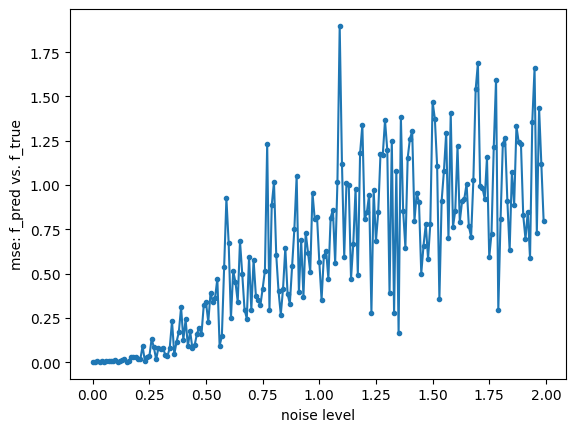

In [17]:
scales = np.arange(0.0,2,0.01)   
mses_P = [] 
for scale in scales:
    # Perturb 
    s_test = np.random.normal(s_train,scale=scale)
    # Scale 
    s_test_s = scaler_s_train.transform(s_test)
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot 
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [18]:
# Perturb  
s_test = np.random.normal(s_train,scale=0.0)
# Scale 
s_test_s = scaler_s_train.transform(s_test) 
# Compute predictions on test 
f_pred_test = krr_optimal_P.predict(s_test_s) 
# True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
f_true_test = f_true_Test(model, s_test) 

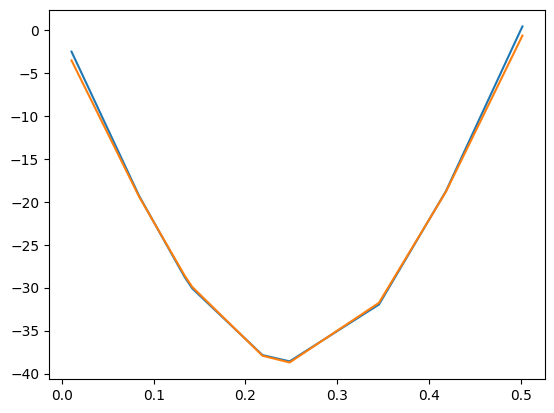

In [19]:
plt.plot(x_train[:e],f_pred_test[:e])
plt.plot(x_train[:e],f_true_test[:e])

> Test 2: Compute global std $\sigma_{\text{global}}$ of `s_train_s` and perturb directly `s_train_s` using $m \sigma_{\text{global}}$ each element. $m \in (0.00,0.25)$.

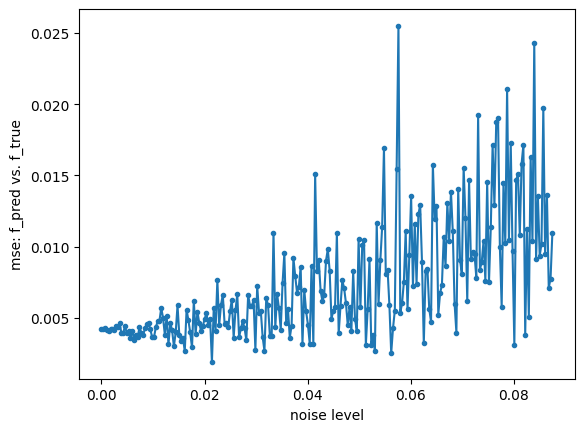

In [20]:
# Compute global std of s_train_s
global_std = np.std(s_train_s)

scales = np.arange(0.0,0.25,0.001)*global_std   
mses_P = [] 
for scale in scales:
    # Perturb scaled training data
    s_test_s = np.random.normal(s_train_s,scale=scale)
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    s_test = scaler_s_train.inverse_transform(s_test_s)
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot 
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

> Test 3: Compute std per feature i $\sigma_{\text{s[:,i]}}$ of `s_train_s` and perturb feature i of `s_train_s` using $m \sigma_{\text{s[:,i]}}$ each element. $m \in (0.01,0.25)$.

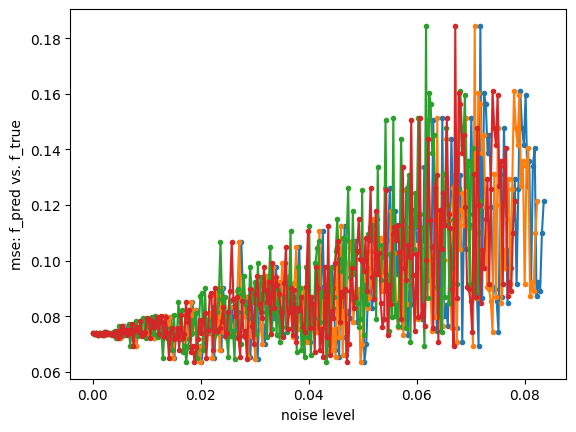

In [21]:
# Compute std per feature of s_train_s
stds = np.std(s_train_s, axis = 0)

scales = np.outer(np.arange(0.0,0.25,0.001),stds)
mses_P = [] 
for i in range(len(scales)):
    # Scales for current iteration
    scale = scales[i,:]
    # Perturb each feature
    for j in range(4):
        s_test_s[:,j] = np.random.normal(s_train_s[:,j] , scale = scale[j])
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [22]:
a = np.sort(np.random.uniform(low = 0.0, high = 1.0, size = 10))
b = np.sort(np.random.choice(a, size=10, replace=False))

In [30]:
import numpy as np
from models import *

np.random.seed(9)
# Pendulum
N = 10 # Number of collocation points
m = 3 # Number of functions
e = 10 # Number of non-zero elements
# N equidistant points in [0,1]
x_train = np.sort(np.random.uniform(low = 0.0, high = 1.0, size = N))
# Choose m times e points randomly in x_train
x_train1 = np.sort(np.random.choice(x_train, size=e, replace=False))
x_train2 = np.sort(np.random.choice(x_train, size=e, replace=False))
x_train3 = np.sort(np.random.choice(x_train, size=e, replace=False))
# Concatenate
x_train = np.concatenate([x_train1,x_train2,x_train3])

In [31]:
x_train

array([0.01037415, 0.08405965, 0.13382953, 0.14211109, 0.21855868,
       0.24810117, 0.34549864, 0.41850818, 0.49577329, 0.50187459,
       0.01037415, 0.08405965, 0.13382953, 0.14211109, 0.21855868,
       0.24810117, 0.34549864, 0.41850818, 0.49577329, 0.50187459,
       0.01037415, 0.08405965, 0.13382953, 0.14211109, 0.21855868,
       0.24810117, 0.34549864, 0.41850818, 0.49577329, 0.50187459])